In [1]:
import testing as tst
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pickle import load, dump 
import math
import datetime

# Import data, model, scalers, in_size

In [29]:
nombres1=['tiempo','Direct','Global','Difusa','Temperatura','Humedad','Presion','alturasolar','azimuth']
esoru=tst.importa('../../01_weather_data/02_cleaned_data/esoru_night_angles.csv',nombres1)
dias_rango=363
forward_steps=dias_rango*144
in_size,out_size= 6,6 
istep=0
model_name='../02_grid_training/01_models/01_models/train_seasonal_layers_3_3_1_out_s_6in_s_6_lr_0.0001_Global_BS24.h5'
model=tst.load_model(model_name)
inputs=['Global','Direct','Temperatura','Humedad','azimuth','alturasolar']
outputs=['Global']
training_step=1
season_size=144
scalery=load(open('../02_grid_training/03_scalers/y_scalerv01.pkl','rb'))
scalerx=load(open('../02_grid_training/03_scalers/x_scalerv01.pkl','rb'))

predi,targ=tst.Multioneshot(esoru,forward_steps,out_size,in_size,istep,model,inputs,outputs,training_step,season_size,scalerx,scalery)

                     Global  Direct  Temperatura  Humedad     azimuth  \
tiempo                                                                  
2019-01-01 00:00:00     0.0     0.0        17.85    59.02  166.773196   
2019-01-01 00:10:00     0.0     0.0        18.29    59.84  170.053742   
2019-01-01 00:20:00     0.0     0.0        17.92    60.08  173.367191   
2019-01-01 00:30:00     0.0     0.0        17.91    61.51  176.703016   
2019-01-01 00:40:00     0.0     0.0        17.94    61.41 -179.949903   
...                     ...     ...          ...      ...         ...   
2019-12-31 23:10:00     0.0     0.0        20.94    58.99  151.345160   
2019-12-31 23:20:00     0.0     0.0        21.20    58.03  154.338568   
2019-12-31 23:30:00     0.0     0.0        21.52    56.33  157.400817   
2019-12-31 23:40:00     0.0     0.0        21.67    57.35  160.527038   
2019-12-31 23:50:00     0.0     0.0        21.31    58.82  163.711070   

                     alturasolar  
tiempo         

## Exporta takes  the imputed data, on the wanted index 

In [30]:
impesoru=tst.seasonal_exporta('../../01_weather_data/02_cleaned_data/esoru_night_angles.csv',predi,istep,in_size,forward_steps,season_size,nombres1,sol_data_correction=True)
impesoru_target=pd.read_csv('../../01_weather_data/02_cleaned_data/esoru_night_angles.csv',names=nombres1,index_col=0,parse_dates=True,skiprows=1)


/Users/aigz/.pyenv/versions/3.9.5/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Visualization

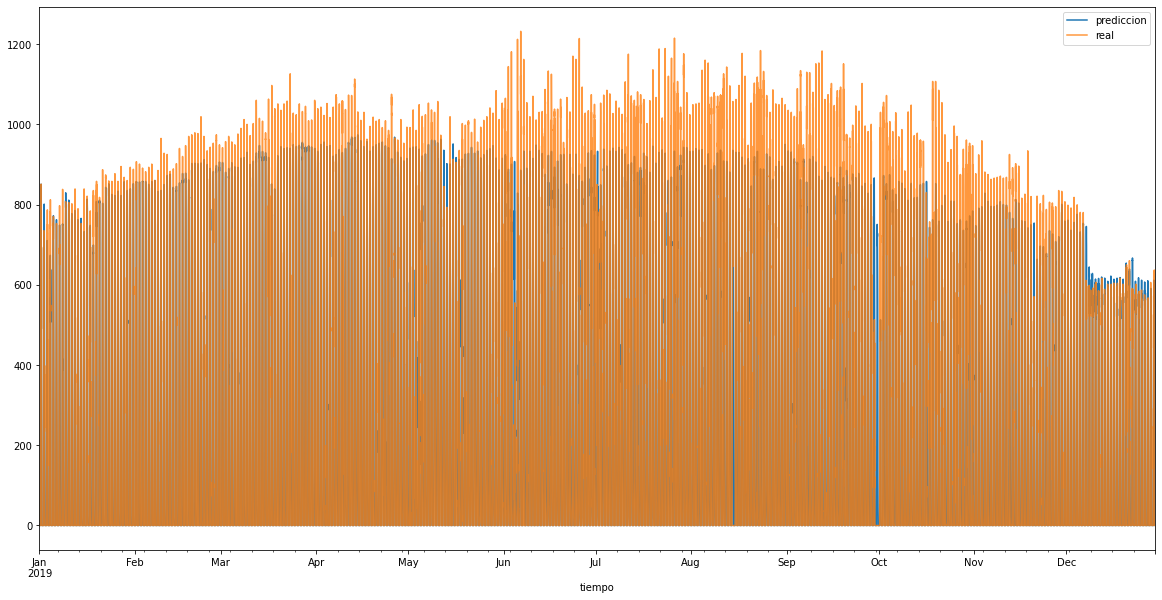

In [31]:
rango=forward_steps
impesoru.Global[istep:istep+rango].plot(figsize=(20,10),alpha=1,label='prediccion')
impesoru_target.Global[istep:istep+rango].plot(alpha=.8,label='real')
plt.legend()

# MAE typical day

diferencia absoluta [w/m2] promedio anual por hora: 2.800293341010835


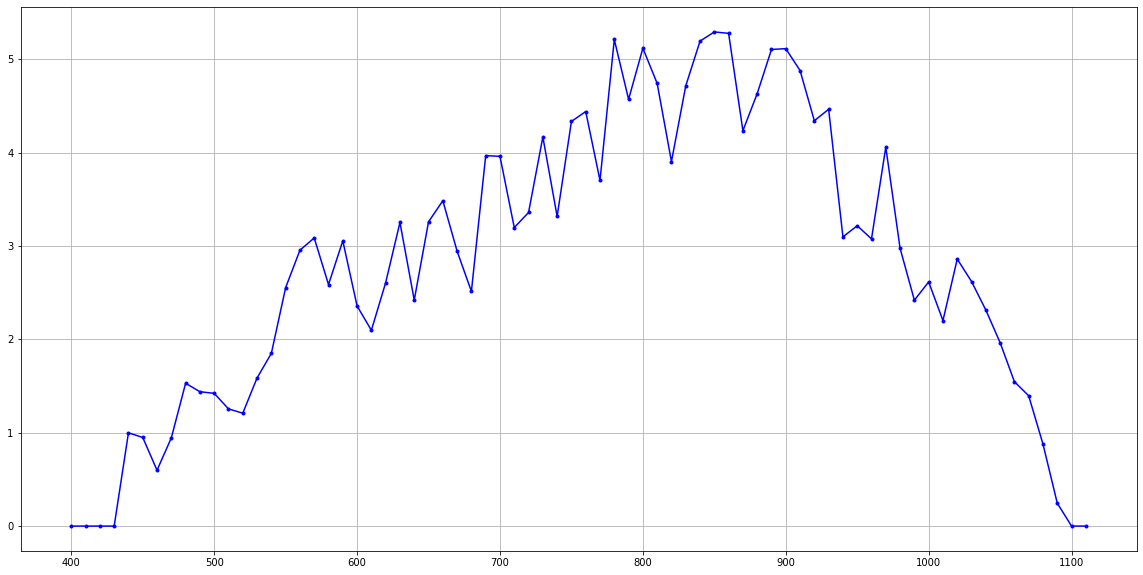

In [18]:
dfrad=impesoru_target.copy()
dfrad['prediccion']=impesoru.Global.copy().astype(float)
dfrad['minutodia']=(dfrad.index.hour*60)+dfrad.index.minute
dfrad['me']=(dfrad.prediccion-dfrad.Global).astype(float)
dfrad['mae']=np.abs(dfrad.Global-dfrad.prediccion).astype(float)
#dfrad.groupby(dfrad.index.to_period('T'))
#Typical day MAE
dfmingroup=dfrad.groupby(['minutodia',pd.Grouper(freq='1H')]).mean()#Agrupaci'on de los promedios de todos los días del año a la misma hora del día 
dfmindia=dfmingroup.groupby(pd.Grouper(level='minutodia',axis=0)).mean() #Se hace un promedio de estos valores (dfmindia)
dfmingroup#['Global','prediccion','mae']
 #Constructing a characteristic mae day
meanaltura=dfmindia.alturasolar.mean()
fig, ax= plt.subplots(figsize=(20,10))
dfmindia.loc[dfmindia.alturasolar<0,'mae']=np.nan #delete the night values 
meandiay=dfmindia.mae.mean()
ax.plot(dfmindia.mae,'b.-')
plt.grid()
print('diferencia absoluta [w/m2] promedio anual por hora:',meandiay) 


(0.0, 500.0)

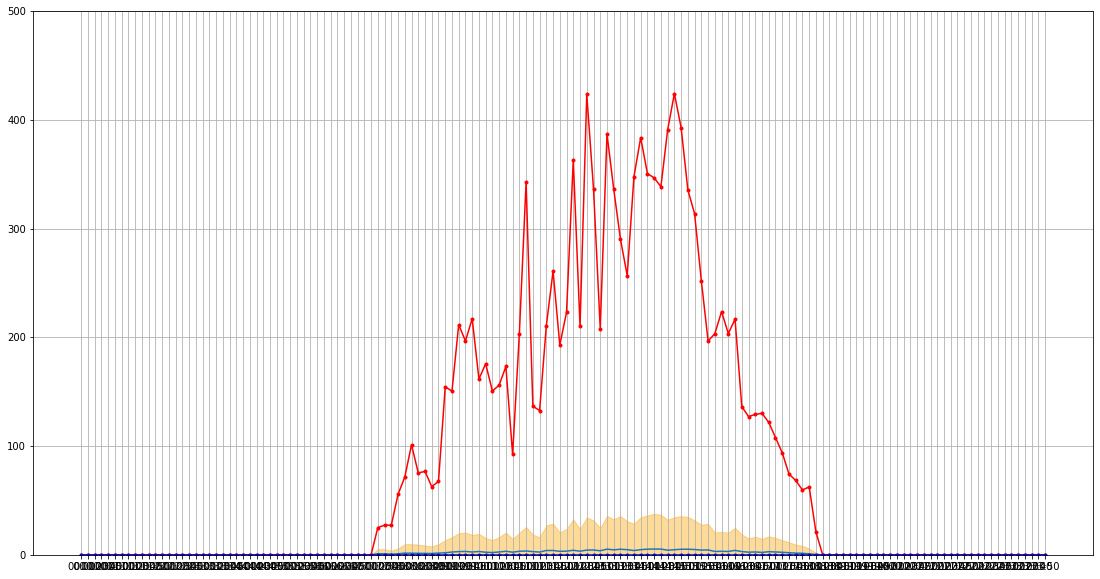

In [16]:
fig, ax= plt.subplots(figsize=(19,10))
dfted=dfrad.mae.groupby(by=[dfrad.index.strftime('%H:%M')]).agg(['mean','std','max','min'])
ax.plot(dfted['mean'])
ax.fill_between(dfted.index,dfted['mean']+dfted['std'],dfted['mean']-dfted['std'],color='orange', alpha=0.4)
ax.plot(dfted['max'],'r.-')
ax.plot(dfted['min'],'b.-')
ax.grid()
plt.ylim(0,500)

# Metrics cycle to grid search selection

In [10]:
#Input data
nombres1=['tiempo','Direct','Global','Difusa','Temperatura','Humedad','Presion','alturasolar','azimuth']
esoru=tst.importa('../../01_weather_data/02_cleaned_data/esoru_night_angles.csv',nombres1)
dias_rango=20#363
forward_steps=dias_rango*144
in_size,out_size= 6,6 
istep=0
inputs=['Global','Direct','Temperatura','Humedad','azimuth','alturasolar']
outputs=['Global']
training_step=1
season_size=144
scalery=load(open('../02_grid_training/03_scalers/y_scalerv01.pkl','rb'))
scalerx=load(open('../02_grid_training/03_scalers/x_scalerv01.pkl','rb'))

tablita=['model','dif_energia_wh','porcentaje_energia','porcentaje_mae','mae_de_día_promedio']
pathtab='02'
nombre_archivotab='metricas_tabla.csv'
path_models='../02_grid_training/01_models/01_models/'
listmodels=['train_seasonal_layers_3_3_1_out_s_6in_s_6_lr_0.0001_Global_BS24.h5']
#cycle
for heo in range(len(listmodels)):
    model=tst.load_model(path_models+listmodels[heo])
    
    
    predi,targ=tst.Multioneshot(esoru,forward_steps,out_size,in_size,istep,model,inputs,outputs,training_step,season_size,scalerx,scalery)
    impesoru=tst.seasonal_exporta('../../01_weather_data/02_cleaned_data/esoru_night_angles.csv',predi,istep,in_size,forward_steps,season_size,nombres1,sol_data_correction=True)
    impesoru_target=pd.read_csv('../../01_weather_data/02_cleaned_data/esoru_night_angles.csv',names=nombres1,index_col=0,parse_dates=True,skiprows=1)
    yearly,daily,hourly=tst.dfmetricas(impesoru,impesoru_target,listmodels[heo])
    if heo==0:
        tst.begin_table(yearly,tablita,pathtab,nombre_archivotab)
    if heo>0:
        met=tst.actualizar_bitacora(yearly,tablita,pathtab,nombre_archivotab)
    print(str(heo)+'iteration from '+str(len(listmodels)-1)+'total_iterations')

                     Global  Direct  Temperatura  Humedad     azimuth  \
tiempo                                                                  
2019-01-01 00:00:00     0.0     0.0        17.85    59.02  166.773196   
2019-01-01 00:10:00     0.0     0.0        18.29    59.84  170.053742   
2019-01-01 00:20:00     0.0     0.0        17.92    60.08  173.367191   
2019-01-01 00:30:00     0.0     0.0        17.91    61.51  176.703016   
2019-01-01 00:40:00     0.0     0.0        17.94    61.41 -179.949903   
...                     ...     ...          ...      ...         ...   
2019-12-31 23:10:00     0.0     0.0        20.94    58.99  151.345160   
2019-12-31 23:20:00     0.0     0.0        21.20    58.03  154.338568   
2019-12-31 23:30:00     0.0     0.0        21.52    56.33  157.400817   
2019-12-31 23:40:00     0.0     0.0        21.67    57.35  160.527038   
2019-12-31 23:50:00     0.0     0.0        21.31    58.82  163.711070   

                     alturasolar  
tiempo         

/Users/aigz/.pyenv/versions/3.9.5/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
